In [2]:
import os
import pandas as pd
import numpy as np
import re
import string
import json
import zipfile
import matplotlib.pyplot as plt
from os.path import isfile, join
from random import sample 
import sqlalchemy as sa
import ast
from json.decoder import JSONDecodeError
import seaborn as sns
from functools import reduce
import warnings
import tqdm
from tqdm.notebook import tqdm, trange
import time
import pykakasi
import sqlite3
from thefuzz import process
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm, trange

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,roc_curve,auc,precision_recall_fscore_support
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression

/Users/yuikondo/opt/anaconda3/lib/python3.9/site-packages/thefuzz/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
tweets_df = pd.read_csv("data/processed/tweets_08010807_notverified.csv")

# 名前辞書とUsernameがMatchした場合

In [3]:
#名前データを読み込む
name_df = pd.read_csv("external.reference/name.gender.japan/datasets/GivenNameGenderV2.csv")
name_df

,GivenName,SurnameCount,Female,Male,Gender,pVal
0,あい,7,7,0,f,1.917624e-05
1,アイ子,2,2,0,f,4.489709e-02
2,あおい,4,4,0,f,2.015748e-03
3,あかね,11,11,0,f,3.865448e-08
4,あかり,9,9,0,f,8.609575e-07
...,...,...,...,...,...,...
2949,颯月,2,2,0,f,4.489709e-02
2950,颯太,15,0,15,m,2.810659e-02
2951,凜,5,4,1,f,8.370279e-03
2952,凜花,2,2,0,f,4.489709e-02


In [4]:
tweets_df['target'] = name_df['GivenName'].apply(lambda n: tweets_df['user_full_name'].str.contains(n)).idxmax()

#matchしたデータセットにsubset化する
tweets_df_match = tweets_df[tweets_df['target'] != 0]
tweets_df_match['target'] = name_df['GivenName'].apply(lambda n: tweets_df_match['user_full_name'].str.contains(n)).idxmax()

In [5]:
name_match = pd.merge(name_df, tweets_df_match, right_on='target', left_index=True, how='right').drop('target', axis=1)

In [6]:
name_match

,GivenName,SurnameCount,Female,Male,Gender,pVal,Unnamed: 0,tweet_id,conversation_id,created_at,...,referenced_user_full_name,referenced_user_following,referenced_user_followers,referenced_user_bio,referenced_tweet_id,referenced_tweet_type,referenced_tweet_text,referenced_tweet_created_at,referenced_tweet_author_id,referenced_tweet_conversation_id
2,実,79.0,1.0,78.0,m,0.001000,2,1.554420e+18,1.554420e+18,2022-08-02T10:53:16.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,一,49.0,0.0,49.0,m,0.001000,6,1.554420e+18,1.554420e+18,2022-08-02T10:52:21.000Z,...,保坂展人,20712.0,119584.0,世田谷区長。ジャーナリスト。96年から09年まで3期11年衆院議員。2011年現職。3期目。...,1.551880e+18,retweeted,問題は、統一教会側の政界工作の対象となって、支援を受けてきた国会議員が、自らの政策判断や主張...,2022-07-26T10:40:56.000Z,1.347766e+08,1.551878e+18
8,蒼,5.0,1.0,4.0,b,0.712766,8,1.554420e+18,1.554420e+18,2022-08-02T10:52:08.000Z,...,わびさび@暫く低浮上,472.0,673.0,日本が大好きです。無言フォローすみません。中傷する人、言葉遣いが悪い人などはブロックします。...,1.554338e+18,retweeted,「選択的夫婦別姓の子供の姓」について統一することが出来てませんよね？\n\n現行法維持派は事...,2022-08-02T05:27:18.000Z,1.228265e+18,1.554338e+18
10,広,13.0,0.0,13.0,m,0.045252,10,1.554420e+18,1.554420e+18,2022-08-02T10:51:33.000Z,...,KENSHIK,901.0,178.0,選択的夫婦別姓 ＦＩＡＴ乗り,1.554081e+18,retweeted,表だって選択的夫婦別姓に反対している団体なんて\n神道政治連盟と幸福の科学、日本会議、\nそ...,2022-08-01T12:26:29.000Z,1.510894e+18,1.554081e+18
14,幸,13.0,10.0,3.0,f,0.000027,14,1.554420e+18,1.256436e+18,2022-08-02T10:51:12.000Z,...,幸ちゃん,4999.0,1738.0,歴史・地理・政治経済・哲学・宗教・皇室・クラシック音楽・鉄道・車・バイク・インコ・ハトなど何...,1.554417e+18,replied_to,あと結婚も問題になってくる。一部の回教国家では一夫多妻を認めており、シリア難民たちもキリスト...,2022-08-02T10:40:39.000Z,2.998443e+09,1.256436e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19819,ゆり,6.0,6.0,0.0,f,0.000091,19815,1.554840e+18,1.554840e+18,2022-08-03T14:41:03.000Z,...,プラトン,4987.0,3212.0,クラシック、ジャズ、フラメンコ鑑賞、読書、絵画鑑賞。\n諸般の事情により再出発となりました。...,1.554810e+18,retweeted,安倍元首相銃撃事件が炙り出した選択的夫婦別姓、同性婚が「論外」とされる理由 https://...,2022-08-03T12:43:04.000Z,7.055164e+17,1.554810e+18
19821,理,44.0,0.0,44.0,m,0.001000,19817,1.554840e+18,1.554840e+18,2022-08-03T14:40:39.000Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19822,雅,16.0,1.0,15.0,b,0.117439,19818,1.554840e+18,1.554840e+18,2022-08-03T14:40:26.000Z,...,塚田 穂高,199.0,25540.0,宗教社会学者。長野市出身。宗教と政治に関する問題や、カルト問題などについてつぶやきます。単著...,1.554837e+18,retweeted,山谷先生、一年生議員の時から、統一教会系『世界日報』（2001.11.25・26）で、「結婚...,2022-08-03T14:31:17.000Z,3.118622e+09,1.554830e+18
19826,治,46.0,0.0,46.0,m,0.001000,19822,1.554840e+18,1.554840e+18,2022-08-03T14:40:03.000Z,...,塚田 穂高,199.0,25540.0,宗教社会学者。長野市出身。宗教と政治に関する問題や、カルト問題などについてつぶやきます。単著...,1.554837e+18,retweeted,山谷先生、一年生議員の時から、統一教会系『世界日報』（2001.11.25・26）で、「結婚...,2022-08-03T14:31:17.000Z,3.118622e+09,1.554830e+18


# 名前辞書とUsernameがMatchしなかった場合：機械学習　

## 教師データ

In [4]:
#教師データをLoad
gender_df = pd.read_csv("data/processed/learning_data.csv")
gender_df

# Check Null values
gender_df.isna().sum()

# Drop values
gender_df.dropna(axis=0,inplace=True)

gender_df

# count the gender column
gender_df['gender'].value_counts()

0.0    507
1.0    493
Name: gender, dtype: int64

## Clean Data

In [5]:
# Import libraries
import re
import spacy
from matplotlib import pyplot as plt

In [6]:
# Clean text
def clean_text(text):
    # Reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # Remove double quotes
    text = re.sub(r'"', '', text)
    text = re.sub(r'、', '', text)
    text = re.sub(r'。', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\u3000', '', text)
    text = re.sub(r'\d+\.*\d*', '0', text)
    return text

gender_df['clean_bio'] = gender_df['user_bio'].apply(clean_text)
gender_df['clean_user_full_name'] = gender_df['user_full_name'].apply(clean_text)
# Remove hyperlinks
gender_df['clean_bio'] = gender_df['clean_bio'].str.replace('http\S+|www.\S+', '', case=False)
# Remove patterns
def remove_pattern(text,pattern):
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    return text

gender_df['clean_bio'] = np.vectorize(remove_pattern)(gender_df['clean_bio'], "@[\w]*") # Removes all @
gender_df['clean_bio'] = np.vectorize(remove_pattern)(gender_df['clean_bio'], "&amp;") # Removes all &

In [7]:
gender_df
gender_df["clean_bio"].to_list()

['SE→退職→山梨で友達と畑→結婚→新宿に戻り夫婦で0年のんびり→0年0月から京都の京丹後市に移住して有機農家「梅本農場」で研修→家を買って定住興味：整体パーマカルチャーNVC畑おしゃべりシーカヤック湯たんぽ灯籠など',
 '♀',
 'ちかこ',
 '猫好きです他の情報はツイートなどの履歴を見て下さいKeywords: 論理数学物理; 積極財政反緊縮; 反陰謀論批判的思考共和主義(反王制)反差別自由・独立・民主反専制; 猫SF圏論糖質制限武装独立・反自民改憲派反自公維非右翼・非共産脱原発・再エネUBI死刑廃止医療大麻',
 '最近ちょっと政治や社会情勢のtweetやリプが増えてきてしまっているのので名前変えました［趣味:新日本プロレス観戦(TV含)です］フォローはして頂けたらなるべくお返し致します🙇\u200d♂️',
 '俳優青年団青森県十和田市出身FtM. GID.俳優・勉強会の仕事はホームページからご依頼・お問い合わせ下さい●0月舞台ムニ『ことばにない』出演0/0(木)-0(日)/0(土)-0(月) THEATRE E0 KYOTO',
 '見た目国籍不明のアヤシイ人その実は大阪のおばちゃん信仰はキリスト教プロテスタント嫌いなものはレイシズム「東西文明の十字路」という言葉に弱い🇹🇷好き(ただしアヤソフィア聖堂のモスク化は憂う)性格は穏やかです#実技試験桜組',
 'Wife-loving, corgi/Akita-adoring & NFC-serving human trying to find beauty in Japan. Ex-Zoo/Van Ness, Zamalek dweller. Usual disclaimers. Enjoy life together.',
 '君が代は千代に八千代にさざれ石の巌となりて苔のむすまで／ 私のリツイートは必ずしも賛同ではない事をここに宣言致します',
 '成人済み腐女子履修履歴/最新はアロルク0ギャクラレオ強竜赤青他にも作家と准教授のあれとシノヤマとか色々あんまり地雷はないあとイカやってます',
 '❤️トピア垢💙不定期で歌枠やってます ♯Palette LIKE→ヨルシカ/YOASOBI/傘村トータ/梶浦由記/澤野弘之/音ゲー/アニメ',
 'アイコン→紅猫りお ヘッダー→みつばちさん 🐝 (*´︶`

In [13]:
## Remove Stop Words (WIP)

## Build a model

In [8]:
#import libraries
import MeCab
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

text_list = gender_df["clean_bio"].to_list()
 
    
#分かち書き
for i in range(len(text_list)):
    mecab = MeCab.Tagger ("-Owakati")
    text_list[i] = mecab.parse (text_list[i])
    
text_list[3]

#テキスト変換
bow = CountVectorizer(min_df=10)
count = bow.fit_transform(text_list)
vec = count.toarray()
name = bow.get_feature_names()
words_df = pd.DataFrame(vec, columns=name)

In [9]:
# words_df.sum(words_df.sum() > 500)
# words_df.sum().to_list()
# words_df[words_df.sum() >= 2]
# words_df_updated = words_df.append([words_df.sum()])
# words_df_updated.iloc[-1] >= 2

words_df.sum()

# if words_df.sum() >= 2:
#     print(words_df)
# for i in words_df:
#     words_df[i].sum() >= 2
# for i in words_df:
#     if(words_df[i].sum() >= 2):
    

# 極端に出現回数が少ない、もしくは多すぎる単語は除去する

dm         29
no         18
rt         85
the        11
twitter    28
           ..
韓国         20
音楽         52
願い         38
高市         13
高校         12
Length: 326, dtype: int64

In [10]:
words_df

,dm,no,rt,the,twitter,あっ,あまり,あらゆる,あり,ありがとう,...,関心,限り,障害,雑多,雑食,韓国,音楽,願い,高市,高校
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Splitting the data into training and test set
words_df
X = words_df
y = gender_df['gender']

# Use Bag-of-words features
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, y, test_size=0.20)


### Logistic Regression

In [13]:
# Fitting on Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_bow, y_train_bow)
prediction_bow = logreg.predict_proba(X_test_bow)
# Calculating the F1 score
# If prediction is greater than or equal to 0.5 than 1, else 0
# Gender, 0 = female and 1 = male
prediction_int = prediction_bow[:,1]>=0.5
prediction_int = prediction_int.astype(np.int)
# Calculating F1 score
log_bow = f1_score(y_test_bow, prediction_int)
log_bow

0.5583756345177665

In [49]:
#ボキャブラリ
len(bow.vocabulary_)

326

In [48]:
#寄与度
len(logreg.coef_[0])

326

Train Accuracy 0.9
Test Accuracy 0.9
Accuracy of Logistic Regression Model: 
 0.56
Confusion Matrix of Logistic Regression Model: 
 [[100  57]
 [ 75  68]]
Logistic Regression Model Classification Report: 
               precision    recall  f1-score   support

         0.0       0.57      0.64      0.60       157
         1.0       0.54      0.48      0.51       143

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.55       300
weighted avg       0.56      0.56      0.56       300

(0.5577142857142857, 0.5562335753418556, 0.5549361625606906, None)


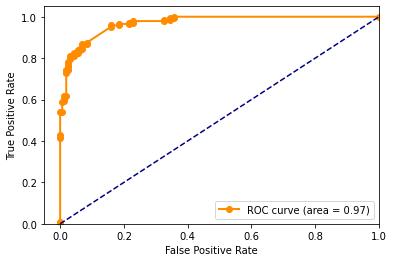

In [69]:
# build logistic model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
# fit model to training set
logistic_model.fit(X_train, y_train)

# predict test set with model
predictions = logistic_model.predict(X_test)
predictions

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
logistic_model.fit(X_train,y_train)

# Predict test set
predictions = logistic_model.predict(X_test)
predictions

# Model Evaluation
score = cross_val_score(logistic_model,X_train,y_train,cv=10).mean()
score.mean()

predicted_Train = logistic_model.fit(X_train, y_train).predict(X_test)
print('Train Accuracy',round(logistic_model.score(X_train, y_train), 2))

predicted_Test = logistic_model.fit(X_test, y_test).predict(X_test)
print('Test Accuracy',round(logistic_model.score(X_test, y_test), 2))

logistic_preds = cross_val_predict(logistic_model,X_test,y_test,cv=10)
logistic_preds

# print the accuracy rate
print("Accuracy of Logistic Regression Model:","\n", accuracy_score(y_test, logistic_preds, normalize=True, sample_weight=None))

# print the confusion matrix
print("Confusion Matrix of Logistic Regression Model:", "\n", confusion_matrix(y_test, logistic_preds))
print("Logistic Regression Model Classification Report:","\n", classification_report(y_test, logistic_preds))
print(precision_recall_fscore_support(y_test, logistic_preds, average='macro'))

#ROC 
logistic_pred_prob = logistic_model.predict_proba(X_test)
logistic_fpr, logistic_tpr, thresholds = roc_curve(y_test, logistic_pred_prob[:,1], pos_label=1)
roc_auc_log_1=auc(logistic_fpr, logistic_tpr)

plt.figure()
lw = 2
plt.plot(logistic_fpr, logistic_tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_log_1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Decision Tree

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
depths = np.arange(6,13,2)
num_leafs_nodes = np.arange(10,61,10)
min_samples_leaf = np.arange(10,91,20)

grid = [{'max_depth':depths,'max_leaf_nodes':num_leafs_nodes, 'min_samples_leaf':min_samples_leaf}]

decision_tree_model = GridSearchCV(DecisionTreeClassifier(), param_grid=grid, cv=10)
decision_tree_model.fit(X_train,y_train)
decision_tree_model.best_params_

{'max_depth': 10, 'max_leaf_nodes': 10, 'min_samples_leaf': 10}

Train Accuracy 0.63
Test Accuracy 0.65
Accuracy of Decision Tree Model: 
 0.52
Confusion Matrix of Decision Tree Model: 
 [[ 44  94]
 [ 50 112]]
Decision Tree Model Classification Report: 
               precision    recall  f1-score   support

         0.0       0.47      0.32      0.38       138
         1.0       0.54      0.69      0.61       162

    accuracy                           0.52       300
   macro avg       0.51      0.51      0.49       300
weighted avg       0.51      0.52      0.50       300

(0.5058872133856641, 0.5050993022007515, 0.49400299850074963, None)


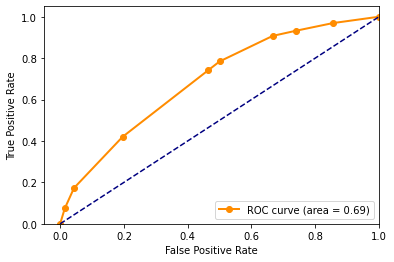

In [64]:
# best params の結果
DT_model = DecisionTreeClassifier(max_depth = 10, max_leaf_nodes = 10, min_samples_leaf = 10)
DT_model.fit(X_train,y_train)
pred_val = DT_model.predict(X_test)

score = cross_val_score(DT_model,X_train,y_train,cv=10).mean()
score.mean()

predicted_Train = DT_model.fit(X_train, y_train).predict(X_test)
print('Train Accuracy',round(DT_model.score(X_train, y_train), 2))

predicted_Test = DT_model.fit(X_test, y_test).predict(X_test)
print('Test Accuracy',round(DT_model.score(X_test, y_test), 2))

DT_preds = cross_val_predict(DT_model,X_test,y_test,cv=10)
DT_preds

# print the accuracy rate
print("Accuracy of Decision Tree Model:","\n", accuracy_score(y_test, DT_preds, normalize=True, sample_weight=None))

# print the confusion matrix
print("Confusion Matrix of Decision Tree Model:", "\n", confusion_matrix(y_test, DT_preds))
print("Decision Tree Model Classification Report:","\n", classification_report(y_test, DT_preds))
print(precision_recall_fscore_support(y_test, DT_preds, average='macro'))

#ROC 
DT_pred_prob = DT_model.predict_proba(X_test)
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT_pred_prob[:,1], pos_label=1)
roc_auc_dt_2=auc(DT_fpr, DT_tpr)

plt.figure()
lw = 2
plt.plot(DT_fpr, DT_tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_dt_2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Naive Bayes

gender
0.0    0.507
1.0    0.493
dtype: float64
Score:  0.6128571428571428
Train Accuracy 0.98
Test Accuracy 0.99
Accuracy of Benchmark Model: 
 0.48857142857142855
Accuracy of Naive Bayes Model: 
 0.6128571428571429
Confusion Matrix of Benchmark Model: 
 [[342   0]
 [358   0]]
Benchmark Model Classification Report: 
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       342
         1.0       0.00      0.00      0.00       358

    accuracy                           0.49       700
   macro avg       0.24      0.50      0.33       700
weighted avg       0.24      0.49      0.32       700

Confusion Matrix of Naive Bayes Model: 
 [[232 110]
 [161 197]]
Naive Bayes Model Classification Report: 
               precision    recall  f1-score   support

         0.0       0.59      0.68      0.63       342
         1.0       0.64      0.55      0.59       358

    accuracy                           0.61       700
   macro avg       0.62     

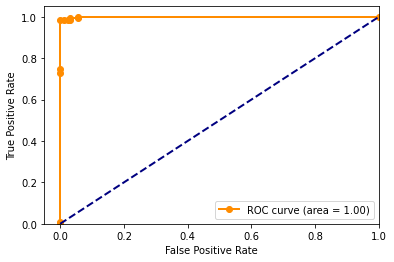

In [67]:
prior = gender_df.groupby('gender').size().div(len(gender_df)) #count()['Age']/len(data)
print(prior)
#Create a Multinomial Bayes Classifier
mnb = MultinomialNB()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
mnb.fit(X_train,y_train)

# Predict test set
test_pred = mnb.predict(X_test)

# Model Evaluation
score = cross_val_score(mnb,X_train,y_train,cv=10).mean()
print('Score: ',score.mean())

predicted_Train = mnb.fit(X_train, y_train).predict(X_test)
print('Train Accuracy',round(mnb.score(X_train, y_train), 2))

predicted_Test = mnb.fit(X_test, y_test).predict(X_test)
print('Test Accuracy',round(mnb.score(X_test, y_test), 2))

pred_y = cross_val_predict(mnb,X_train,y_train,cv=10)

# Do majority-class prediction (not accept: 0) -> Benchmark model
pred_val_maj = np.zeros((X_train.shape[0],),dtype=int)

# print the accurary rate
print("Accuracy of Benchmark Model:","\n", accuracy_score(y_train, pred_val_maj, normalize=True, sample_weight=None))
print("Accuracy of Naive Bayes Model:","\n", accuracy_score(y_train, pred_y, normalize=True, sample_weight=None))

# print the confusion matrix
print("Confusion Matrix of Benchmark Model:", "\n", confusion_matrix(y_train, pred_val_maj))
print("Benchmark Model Classification Report:","\n", classification_report(y_train, pred_val_maj))
print("Confusion Matrix of Naive Bayes Model:", "\n", confusion_matrix(y_train, pred_y))
print("Naive Bayes Model Classification Report:","\n", classification_report(y_train, pred_y))
print(precision_recall_fscore_support(y_train, pred_y,average='macro'))

#ROC 
pred_prob = mnb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_prob[:,1], pos_label=1)
roc_auc_nb_1=auc(fpr,tpr)

%matplotlib inline

plt.figure()
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_nb_1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

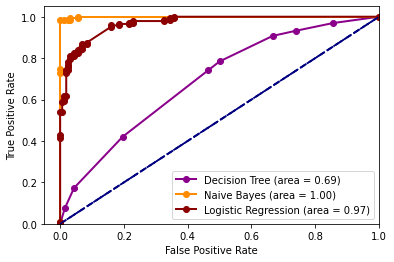

In [70]:
#DT
plt.figure()
lw = 2
plt.plot(DT_fpr, DT_tpr, marker='o',color='darkmagenta',
         lw=lw, label='Decision Tree (area = %0.2f)' % roc_auc_dt_2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")


#NB
lw = 2
plt.plot(fpr, tpr, marker='o',color='darkorange',
         lw=lw, label='Naive Bayes (area = %0.2f)' % roc_auc_nb_1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")

#Logistic

lw = 2
plt.plot(logistic_fpr, logistic_tpr, marker='o',color='darkred',
         lw=lw, label='Logistic Regression (area = %0.2f)' % roc_auc_log_1)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

## use Logistic Regression to predict the gender of tweeter

In [14]:
# subset
tweets_df_unmatch = tweets_df[tweets_df['target'] == 0]

KeyError: 'target'

In [15]:
tweets_df

,Unnamed: 0,tweet_id,conversation_id,created_at,text,retweet_count,reply_count,like_count,quote_count,user_id,...,referenced_user_full_name,referenced_user_following,referenced_user_followers,referenced_user_bio,referenced_tweet_id,referenced_tweet_type,referenced_tweet_text,referenced_tweet_created_at,referenced_tweet_author_id,referenced_tweet_conversation_id
0,0,1.554420e+18,1.554420e+18,2022-08-02T10:53:43.000Z,RT @5sasha5sasha5: 旧統一教会と政治の関係 塚田穂高氏「国会で検証し国民に...,109.0,0.0,0.0,0,955549208,...,サーシャサーシャ🇺🇦,1068.0,826.0,一市民です。過去は変えられないが、未来は人びとの選択で変えられる。人びとが原発のない日本、そ...,1.554346e+18,retweeted,旧統一教会と政治の関係 塚田穂高氏「国会で検証し国民に明示を」 | 毎日新聞 https:/...,2022-08-02T06:00:34.000Z,4.159746e+08,1.554346e+18
1,1,1.554420e+18,1.554420e+18,2022-08-02T10:53:20.000Z,RT @ssimtok: 旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教...,417.0,0.0,0.0,0,108143787,...,松岡宗嗣,2881.0,29697.0,ライター／一般社団法人fair代表理事。シスジェンダー・ゲイです。初の単著『あいつゲイだって...,1.554410e+18,retweeted,旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教育、ジェンダーフリー、男女...,2022-08-02T10:13:47.000Z,3.140360e+09,1.554410e+18
2,2,1.554420e+18,1.554420e+18,2022-08-02T10:53:16.000Z,選択的夫婦別姓制度は、全ての人に夫婦別姓を求めるものではありません。夫婦別姓を求める夫婦には...,1.0,0.0,3.0,0,916384875258699776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.554420e+18,1.554420e+18,2022-08-02T10:53:09.000Z,RT @ssimtok: 旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教...,417.0,0.0,0.0,0,967350118557995008,...,松岡宗嗣,2881.0,29697.0,ライター／一般社団法人fair代表理事。シスジェンダー・ゲイです。初の単著『あいつゲイだって...,1.554410e+18,retweeted,旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教育、ジェンダーフリー、男女...,2022-08-02T10:13:47.000Z,3.140360e+09,1.554410e+18
4,4,1.554420e+18,1.554358e+18,2022-08-02T10:52:47.000Z,@sabutibi777 よくある、「俺の周りで、夫婦別姓に賛成してる奴なんか見たことない」...,0.0,1.0,3.0,0,1350467320980803587,...,さちSHIAゆ〜,187.0,219.0,自分の名前のまま生きていく。お互い改姓しない、法的な結婚を希望します。結果的に選択的夫婦別姓...,1.554367e+18,replied_to,@subaru1000 新郎新婦側からも、縁を切ることできる良い機会です。,2022-08-02T07:21:52.000Z,1.408581e+18,1.554358e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19829,19825,1.554839e+18,1.554839e+18,2022-08-03T14:39:39.000Z,「選択的夫婦別姓」にすると「家庭が崩壊」するから反対という山谷は、「統一教会への献金」で貧困...,0.0,1.0,0.0,0,118639042,...,Kako（kakopon）,7839.0,20538.0,自由と平和と民主主義を愛する大阪市民。護憲派。肉球新党。投票倍増委員会。危機的な状況のため、...,1.554759e+18,quoted,「日本の素晴らしい歴史と生命を守りたい」と言われていましたよね。山谷さんなら、「素晴らしい日...,2022-08-03T09:19:48.000Z,2.285384e+08,1.554759e+18
19830,19826,1.554839e+18,1.554839e+18,2022-08-03T14:39:07.000Z,RT @oriak9: 選択的夫婦別姓の話に現れる「夫婦同姓がいい人はどうするんですか！？」...,2263.0,0.0,0.0,0,1351005315702120456,...,ハンドクリームを塗る機械の錆,3573.0,532.0,逆さまの猫画像を見ると喜ぶ人です。成人済。雑食。BLGLHLなんでも好き。審神者兼マスター兼...,1.554306e+18,retweeted,選択的夫婦別姓の話に現れる「夫婦同姓がいい人はどうするんですか！？」、ハイヒール強制やめよう...,2022-08-02T03:18:11.000Z,3.223432e+09,1.554306e+18
19831,19827,1.554839e+18,1.554839e+18,2022-08-03T14:38:37.000Z,RT @hotaka_tsukada: 山谷先生、一年生議員の時から、統一教会系『世界日報』...,1743.0,0.0,0.0,0,118742488,...,塚田 穂高,199.0,25540.0,宗教社会学者。長野市出身。宗教と政治に関する問題や、カルト問題などについてつぶやきます。単著...,1.554837e+18,retweeted,山谷先生、一年生議員の時から、統一教会系『世界日報』（2001.11.25・26）で、「結婚...,2022-08-03T14:31:17.000Z,3.118622e+09,1.554830e+18
19832,19828,1.554839e+18,1.554839e+18,2022-08-03T14:38:05.000Z,RT @futaba28281: @mainichi どう考えてもどっぷり洗脳されてるよ。夫...,2.0,0.0,0.0,0,936949211886641154,...,ジョジョ猫,117.0,37.0,「人間の愚かさを侮ってはならない」歴史家のユヴァルさんの言葉を実感してます。矛盾だらけの人間...,1.554754e+18,retweeted,@mainichi どう考えてもどっぷり洗脳されてるよ。夫婦別姓、同性婚、などなど先頭きって...,2022-08-03T08:58:48.000Z,2.940879e+09,1.554669e+18


In [16]:
#user_bioが含まれていないユーザーの欠損値処理（削除する）　＊平均値で補うのもありかも。
tweets_df_bio_dropped = tweets_df.dropna(subset=["user_bio"])

### Clean Text

In [17]:
# Clean text
def clean_text(text):
    # Reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # Remove double quotes
    text = re.sub(r'"', '', text)
    text = re.sub(r'、', '', text)
    text = re.sub(r'。', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\u3000', '', text)
    text = re.sub(r'\d+\.*\d*', '0', text)
    return text

tweets_df_bio_dropped['clean_bio'] = tweets_df_bio_dropped['user_bio'].apply(clean_text)
# Remove hyperlinks
tweets_df_bio_dropped['clean_bio'] = tweets_df_bio_dropped['clean_bio'].str.replace('http\S+|www.\S+', '', case=False)
# Remove patterns
def remove_pattern(text,pattern):
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    return text

tweets_df_bio_dropped['clean_bio'] = np.vectorize(remove_pattern)(tweets_df_bio_dropped['clean_bio'], "@[\w]*") # Removes all @
tweets_df_bio_dropped['clean_bio'] = np.vectorize(remove_pattern)(tweets_df_bio_dropped['clean_bio'], "&amp;") # Removes all &

In [18]:
text_list = tweets_df_bio_dropped["clean_bio"].to_list()
    
#分かち書き
for i in range(len(text_list)):
    mecab = MeCab.Tagger ("-Owakati")
    text_list[i] = mecab.parse (text_list[i])
    
text_list[3]


#テキスト変換
count2 = bow.transform(text_list)
vec2 = count2.toarray()
name2 = bow.get_feature_names()

#共通するColumnを抜き出す
# and_name = set(name) & set(name2)
# print(and_name)

words_df_2 = pd.DataFrame(vec2, columns=name2)

In [19]:
words_df_2

,dm,no,rt,the,twitter,あっ,あまり,あらゆる,あり,ありがとう,...,関心,限り,障害,雑多,雑食,韓国,音楽,願い,高市,高校
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16802,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16804,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16805,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#words_df と　words_df_2　のColumnが一致しているもののみ抜き出す。
# test dataと　train dataは切り分けないとならないのでは...?

In [20]:
# Predict probability

z = words_df_2
pred_prob = logreg.predict_proba(z)
pred_prob = pd.DataFrame(data=pred_prob, columns=['percentage_0', 'percentage_1'])
# Predict classification
pred = logreg.predict(z)
pred = pd.DataFrame(data=pred, columns=['predicted_gender'])
# Store into the same DataFrame
result = pd.concat([tweets_df, pred, pred_prob], axis=1, sort=False)
result
# 0 = female, 1 = male

,Unnamed: 0,tweet_id,conversation_id,created_at,text,retweet_count,reply_count,like_count,quote_count,user_id,...,referenced_user_bio,referenced_tweet_id,referenced_tweet_type,referenced_tweet_text,referenced_tweet_created_at,referenced_tweet_author_id,referenced_tweet_conversation_id,predicted_gender,percentage_0,percentage_1
0,0,1.554420e+18,1.554420e+18,2022-08-02T10:53:43.000Z,RT @5sasha5sasha5: 旧統一教会と政治の関係 塚田穂高氏「国会で検証し国民に...,109.0,0.0,0.0,0,955549208,...,一市民です。過去は変えられないが、未来は人びとの選択で変えられる。人びとが原発のない日本、そ...,1.554346e+18,retweeted,旧統一教会と政治の関係 塚田穂高氏「国会で検証し国民に明示を」 | 毎日新聞 https:/...,2022-08-02T06:00:34.000Z,4.159746e+08,1.554346e+18,1.0,0.466053,0.533947
1,1,1.554420e+18,1.554420e+18,2022-08-02T10:53:20.000Z,RT @ssimtok: 旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教...,417.0,0.0,0.0,0,108143787,...,ライター／一般社団法人fair代表理事。シスジェンダー・ゲイです。初の単著『あいつゲイだって...,1.554410e+18,retweeted,旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教育、ジェンダーフリー、男女...,2022-08-02T10:13:47.000Z,3.140360e+09,1.554410e+18,1.0,0.466053,0.533947
2,2,1.554420e+18,1.554420e+18,2022-08-02T10:53:16.000Z,選択的夫婦別姓制度は、全ての人に夫婦別姓を求めるものではありません。夫婦別姓を求める夫婦には...,1.0,0.0,3.0,0,916384875258699776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.857618,0.142382
3,3,1.554420e+18,1.554420e+18,2022-08-02T10:53:09.000Z,RT @ssimtok: 旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教...,417.0,0.0,0.0,0,967350118557995008,...,ライター／一般社団法人fair代表理事。シスジェンダー・ゲイです。初の単著『あいつゲイだって...,1.554410e+18,retweeted,旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教育、ジェンダーフリー、男女...,2022-08-02T10:13:47.000Z,3.140360e+09,1.554410e+18,1.0,0.466053,0.533947
4,4,1.554420e+18,1.554358e+18,2022-08-02T10:52:47.000Z,@sabutibi777 よくある、「俺の周りで、夫婦別姓に賛成してる奴なんか見たことない」...,0.0,1.0,3.0,0,1350467320980803587,...,自分の名前のまま生きていく。お互い改姓しない、法的な結婚を希望します。結果的に選択的夫婦別姓...,1.554367e+18,replied_to,@subaru1000 新郎新婦側からも、縁を切ることできる良い機会です。,2022-08-02T07:21:52.000Z,1.408581e+18,1.554358e+18,0.0,0.522242,0.477758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19829,19825,1.554839e+18,1.554839e+18,2022-08-03T14:39:39.000Z,「選択的夫婦別姓」にすると「家庭が崩壊」するから反対という山谷は、「統一教会への献金」で貧困...,0.0,1.0,0.0,0,118639042,...,自由と平和と民主主義を愛する大阪市民。護憲派。肉球新党。投票倍増委員会。危機的な状況のため、...,1.554759e+18,quoted,「日本の素晴らしい歴史と生命を守りたい」と言われていましたよね。山谷さんなら、「素晴らしい日...,2022-08-03T09:19:48.000Z,2.285384e+08,1.554759e+18,NaN,NaN,NaN
19830,19826,1.554839e+18,1.554839e+18,2022-08-03T14:39:07.000Z,RT @oriak9: 選択的夫婦別姓の話に現れる「夫婦同姓がいい人はどうするんですか！？」...,2263.0,0.0,0.0,0,1351005315702120456,...,逆さまの猫画像を見ると喜ぶ人です。成人済。雑食。BLGLHLなんでも好き。審神者兼マスター兼...,1.554306e+18,retweeted,選択的夫婦別姓の話に現れる「夫婦同姓がいい人はどうするんですか！？」、ハイヒール強制やめよう...,2022-08-02T03:18:11.000Z,3.223432e+09,1.554306e+18,NaN,NaN,NaN
19831,19827,1.554839e+18,1.554839e+18,2022-08-03T14:38:37.000Z,RT @hotaka_tsukada: 山谷先生、一年生議員の時から、統一教会系『世界日報』...,1743.0,0.0,0.0,0,118742488,...,宗教社会学者。長野市出身。宗教と政治に関する問題や、カルト問題などについてつぶやきます。単著...,1.554837e+18,retweeted,山谷先生、一年生議員の時から、統一教会系『世界日報』（2001.11.25・26）で、「結婚...,2022-08-03T14:31:17.000Z,3.118622e+09,1.554830e+18,NaN,NaN,NaN
19832,19828,1.554839e+18,1.554839e+18,2022-08-03T14:38:05.000Z,RT @futaba28281: @mainichi どう考えてもどっぷり洗脳されてるよ。夫...,2.0,0.0,0.0,0,936949211886641154,...,「人間の愚かさを侮ってはならない」歴史家のユヴァルさんの言葉を実感してます。矛盾だらけの人間...,1.554754e+18,retweeted,@mainichi どう考えてもどっぷり洗脳されてるよ。夫婦別姓、同性婚、などなど先頭きって...,2022-08-03T08:58:48.000Z,2.940879e+09,1.554669e+18,NaN,NaN,NaN


In [21]:
result[['username','user_bio','predicted_gender']][121:140]

,username,user_bio,predicted_gender
121,WgFZQRk2v6m90cL,日本在住。ダイエット中の微年金バイトおじん。久留米『融流渡辺党松浦水軍の末裔なのにトンカチで...,1.0
122,PmsaNvv,🇯🇵のことが大好きです\n右でも左でもなく、美しい🇯🇵をカルト教団から取り戻したい,1.0
123,syohani,関西圏のゲーム好き。守備範囲 HOI2、CIV、EXVS、elona、civ4等 最近はFG...,1.0
124,888moko,NaN,0.0
125,MotoBuch1228,歌う憲法学者です。単著『政治的公共圏の憲法理論』・『現代政党国家の危機と再生』、編著『グロー...,0.0
126,kumaani_hosi,クマアニです、宜しくです（＾＾\n申しおくれました･･･\nおっちゃんです (ーー;\n仕事...,0.0
127,mtmt29547371,日本を害する者・日本人を迫害する者と戦う。\n私はそう決めた。\n反ワクチン,0.0
128,yu_kotyan,NaN,0.0
129,Yb7vZ,通りすがりのただのネコ狂いです。\n綺麗なものが好き。綺麗事はクソ。\n爆音、動物の声、フォ...,1.0
130,sibasibatales,好きなもの\n柴犬、猫、ポケモン、唐揚げ、焼肉、米。\n嫌いなもの\nナイアン、ブロッコリー...,1.0


## Predict gender of referenced user

In [22]:
#欠損値処理
referenced_user_dropped = tweets_df.dropna(subset=["referenced_user_bio"])
#Clean Text
referenced_user_dropped['referenced_clean_bio'] = referenced_user_dropped['referenced_user_bio'].apply(clean_text)
# Remove hyperlinks
referenced_user_dropped['referenced_clean_bio'] = referenced_user_dropped['referenced_clean_bio'].str.replace('http\S+|www.\S+', '', case=False)
# Remove patterns
def remove_pattern(text,pattern):
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    return text

referenced_user_dropped['referenced_clean_bio'] = np.vectorize(remove_pattern)(referenced_user_dropped['referenced_clean_bio'], "@[\w]*") # Removes all @
referenced_user_dropped['referenced_clean_bio'] = np.vectorize(remove_pattern)(referenced_user_dropped['referenced_clean_bio'], "&amp;") # Removes all &

referenced_text_list = referenced_user_dropped["referenced_clean_bio"].to_list()

referenced_user_dropped['referenced_clean_bio']

0        一市民です過去は変えられないが未来は人びとの選択で変えられる人びとが原発のない日本そして世界...
1        ライター／一般社団法人fair代表理事シスジェンダー・ゲイです初の単著『あいつゲイだって-ア...
3        ライター／一般社団法人fair代表理事シスジェンダー・ゲイです初の単著『あいつゲイだって-ア...
4        自分の名前のまま生きていくお互い改姓しない法的な結婚を希望します結果的に選択的夫婦別姓賛成屁...
5        松丸誠 前足立区議会議員 ですTwitter保守の政治家として国を守り国民のために働きます私...
                               ...                        
19829    自由と平和と民主主義を愛する大阪市民護憲派肉球新党投票倍増委員会危機的な状況のため政治アカウ...
19830    逆さまの猫画像を見ると喜ぶ人です成人済雑食BLGLHLなんでも好き審神者兼マスター兼騎空士桐...
19831    宗教社会学者長野市出身宗教と政治に関する問題やカルト問題などについてつぶやきます単著『宗教と...
19832    「人間の愚かさを侮ってはならない」歴史家のユヴァルさんの言葉を実感してます矛盾だらけの人間と...
19833    宗教社会学者長野市出身宗教と政治に関する問題やカルト問題などについてつぶやきます単著『宗教と...
Name: referenced_clean_bio, Length: 18097, dtype: object

In [23]:
#全部Methodにしたら早そう。


#分かち書き
for i in range(len(referenced_text_list)):
    mecab = MeCab.Tagger ("-Owakati")
    referenced_text_list[i] = mecab.parse (referenced_text_list[i])


#テキスト変換
referenced_count = bow.transform(text_list)
referenced_vec = referenced_count.toarray()
referenced_name = bow.get_feature_names()

words_referenced_df = pd.DataFrame(referenced_vec, columns=referenced_name)

#教師データと共通するデータにする

In [24]:

# Predict probability
z = words_referenced_df
pred_prob_referenced = logreg.predict_proba(z)
pred_prob_referenced = pd.DataFrame(data=pred_prob_referenced, columns=['referenced_percentage_0', 'referenced_percentage_1'])
# Predict classification
pred_referenced = logreg.predict(z)
pred_referenced = pd.DataFrame(data=pred_referenced, columns=['referenced_predicted_gender'])
# Store into the same DataFrame
result_referenced = pd.concat([tweets_df, pred_referenced, pred_prob_referenced], axis=1, sort=False)
result_referenced
# 0 = female, 1 = male

,Unnamed: 0,tweet_id,conversation_id,created_at,text,retweet_count,reply_count,like_count,quote_count,user_id,...,referenced_user_bio,referenced_tweet_id,referenced_tweet_type,referenced_tweet_text,referenced_tweet_created_at,referenced_tweet_author_id,referenced_tweet_conversation_id,referenced_predicted_gender,referenced_percentage_0,referenced_percentage_1
0,0,1.554420e+18,1.554420e+18,2022-08-02T10:53:43.000Z,RT @5sasha5sasha5: 旧統一教会と政治の関係 塚田穂高氏「国会で検証し国民に...,109.0,0.0,0.0,0,955549208,...,一市民です。過去は変えられないが、未来は人びとの選択で変えられる。人びとが原発のない日本、そ...,1.554346e+18,retweeted,旧統一教会と政治の関係 塚田穂高氏「国会で検証し国民に明示を」 | 毎日新聞 https:/...,2022-08-02T06:00:34.000Z,4.159746e+08,1.554346e+18,1.0,0.466053,0.533947
1,1,1.554420e+18,1.554420e+18,2022-08-02T10:53:20.000Z,RT @ssimtok: 旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教...,417.0,0.0,0.0,0,108143787,...,ライター／一般社団法人fair代表理事。シスジェンダー・ゲイです。初の単著『あいつゲイだって...,1.554410e+18,retweeted,旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教育、ジェンダーフリー、男女...,2022-08-02T10:13:47.000Z,3.140360e+09,1.554410e+18,1.0,0.466053,0.533947
2,2,1.554420e+18,1.554420e+18,2022-08-02T10:53:16.000Z,選択的夫婦別姓制度は、全ての人に夫婦別姓を求めるものではありません。夫婦別姓を求める夫婦には...,1.0,0.0,3.0,0,916384875258699776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.857618,0.142382
3,3,1.554420e+18,1.554420e+18,2022-08-02T10:53:09.000Z,RT @ssimtok: 旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教...,417.0,0.0,0.0,0,967350118557995008,...,ライター／一般社団法人fair代表理事。シスジェンダー・ゲイです。初の単著『あいつゲイだって...,1.554410e+18,retweeted,旧統一教会は「家族や性的『純潔』を重視する教えから、夫婦別姓や性教育、ジェンダーフリー、男女...,2022-08-02T10:13:47.000Z,3.140360e+09,1.554410e+18,1.0,0.466053,0.533947
4,4,1.554420e+18,1.554358e+18,2022-08-02T10:52:47.000Z,@sabutibi777 よくある、「俺の周りで、夫婦別姓に賛成してる奴なんか見たことない」...,0.0,1.0,3.0,0,1350467320980803587,...,自分の名前のまま生きていく。お互い改姓しない、法的な結婚を希望します。結果的に選択的夫婦別姓...,1.554367e+18,replied_to,@subaru1000 新郎新婦側からも、縁を切ることできる良い機会です。,2022-08-02T07:21:52.000Z,1.408581e+18,1.554358e+18,0.0,0.522242,0.477758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19829,19825,1.554839e+18,1.554839e+18,2022-08-03T14:39:39.000Z,「選択的夫婦別姓」にすると「家庭が崩壊」するから反対という山谷は、「統一教会への献金」で貧困...,0.0,1.0,0.0,0,118639042,...,自由と平和と民主主義を愛する大阪市民。護憲派。肉球新党。投票倍増委員会。危機的な状況のため、...,1.554759e+18,quoted,「日本の素晴らしい歴史と生命を守りたい」と言われていましたよね。山谷さんなら、「素晴らしい日...,2022-08-03T09:19:48.000Z,2.285384e+08,1.554759e+18,NaN,NaN,NaN
19830,19826,1.554839e+18,1.554839e+18,2022-08-03T14:39:07.000Z,RT @oriak9: 選択的夫婦別姓の話に現れる「夫婦同姓がいい人はどうするんですか！？」...,2263.0,0.0,0.0,0,1351005315702120456,...,逆さまの猫画像を見ると喜ぶ人です。成人済。雑食。BLGLHLなんでも好き。審神者兼マスター兼...,1.554306e+18,retweeted,選択的夫婦別姓の話に現れる「夫婦同姓がいい人はどうするんですか！？」、ハイヒール強制やめよう...,2022-08-02T03:18:11.000Z,3.223432e+09,1.554306e+18,NaN,NaN,NaN
19831,19827,1.554839e+18,1.554839e+18,2022-08-03T14:38:37.000Z,RT @hotaka_tsukada: 山谷先生、一年生議員の時から、統一教会系『世界日報』...,1743.0,0.0,0.0,0,118742488,...,宗教社会学者。長野市出身。宗教と政治に関する問題や、カルト問題などについてつぶやきます。単著...,1.554837e+18,retweeted,山谷先生、一年生議員の時から、統一教会系『世界日報』（2001.11.25・26）で、「結婚...,2022-08-03T14:31:17.000Z,3.118622e+09,1.554830e+18,NaN,NaN,NaN
19832,19828,1.554839e+18,1.554839e+18,2022-08-03T14:38:05.000Z,RT @futaba28281: @mainichi どう考えてもどっぷり洗脳されてるよ。夫...,2.0,0.0,0.0,0,936949211886641154,...,「人間の愚かさを侮ってはならない」歴史家のユヴァルさんの言葉を実感してます。矛盾だらけの人間...,1.554754e+18,retweeted,@mainichi どう考えてもどっぷり洗脳されてるよ。夫婦別姓、同性婚、などなど先頭きって...,2022-08-03T08:58:48.000Z,2.940879e+09,1.554669e+18,NaN,NaN,NaN


In [222]:
result_referenced_merge = result_referenced[['tweet_id','referenced_percentage_0','referenced_percentage_1','referenced_predicted_gender']]

In [223]:
# 表をMergeする
result_referenced_merge

,tweet_id,referenced_percentage_0,referenced_percentage_1,referenced_predicted_gender
0,1.554420e+18,0.336345,0.663655,1.0
1,1.554420e+18,0.533133,0.466867,0.0
2,1.554420e+18,0.533133,0.466867,0.0
3,1.554420e+18,0.509579,0.490421,0.0
4,1.554420e+18,0.395374,0.604626,1.0
...,...,...,...,...
19829,1.554839e+18,NaN,NaN,NaN
19830,1.554839e+18,NaN,NaN,NaN
19831,1.554839e+18,NaN,NaN,NaN
19832,1.554839e+18,NaN,NaN,NaN


In [230]:
merge_df = pd.merge(result, result_referenced_merge, on='tweet_id', how='inner')

In [287]:
# 欠損値処理
final_df = merge_df[['created_at', 'predicted_gender', 'referenced_predicted_gender']].dropna()
final_df.isnull().sum()
final_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
final_df['created_at_day'] = final_df['created_at'].dt.strftime('%d')

# EI Index

# Internal Links

# Userが女性、Referenced＿Userが女性
woman_woman = final_df[(final_df['predicted_gender'] == 0) & (final_df['referenced_predicted_gender'] == 0)]
# Userが男性、Referenced＿Userが男性
man_man = final_df[(final_df['predicted_gender'] == 1) & (final_df['referenced_predicted_gender'] == 1)]


# External Links

# Userが男性、Referenced＿Userが女性
man_woman = final_df[(final_df['predicted_gender'] == 1) & (final_df['referenced_predicted_gender'] == 0)]
# Userが女性、Referenced＿Userが男性
woman_man = final_df[(final_df['predicted_gender'] == 0) & (final_df['referenced_predicted_gender'] == 1)]



## Internal Links

In [297]:
#woman_woman
woman_woman_count = woman_woman.groupby('created_at_day').count()
woman_woman_count = woman_woman_count.drop(['predicted_gender', 'referenced_predicted_gender'], axis=1)
woman_woman_count = woman_woman_count.rename(columns={'created_at': 'woman_woman'})
woman_woman_count

#man_man
man_man_count = man_man.groupby('created_at_day').count()
man_man_count = man_man_count.drop(['predicted_gender', 'referenced_predicted_gender'], axis=1)
man_man_count = man_man_count.rename(columns={'created_at': 'man_man'})
man_man_count

#merge data
internal_df = pd.merge(woman_woman_count, man_man_count, on='created_at_day', how='inner')
internal_df['internal_links'] = internal_df['man_man'] + internal_df['woman_woman']
internal_df

,woman_woman,man_man,internal_links
created_at_day,,,
01,854,716,1570
02,310,544,854
03,597,473,1070
04,1164,1076,2240
05,641,864,1505
06,465,368,833


## External Links

In [296]:
#man_woman
man_woman_count = man_woman.groupby('created_at_day').count()
man_woman_count = man_woman_count.drop(['predicted_gender', 'referenced_predicted_gender'], axis=1)
man_woman_count = man_woman_count.rename(columns={'created_at': 'man_woman'})

#woman_man
woman_man_count = woman_man.groupby('created_at_day').count()
woman_man_count = woman_man_count.drop(['predicted_gender', 'referenced_predicted_gender'], axis=1)
woman_man_count = woman_man_count.rename(columns={'created_at': 'woman_man'})

#merge data
external_df = pd.merge(man_woman_count, woman_man_count, on='created_at_day', how='inner')

external_df['external_links'] = external_df['man_woman'] + external_df['woman_man']
external_df

,man_woman,woman_man,external_links
created_at_day,,,
01,1296,477,1773
02,466,300,766
03,960,330,1290
04,1740,677,2417
05,1021,547,1568
06,639,276,915


## Overall data

In [302]:
#merge data
overall_df = pd.merge(internal_df, external_df, on='created_at_day', how='inner')
overall_df['sum'] = overall_df['internal_links'] + overall_df['external_links']
overall_df['minus'] = overall_df['external_links'] - overall_df['internal_links']
overall_df['eiindex'] = overall_df['minus'] / overall_df['sum']
overall_df

,woman_woman,man_man,internal_links,man_woman,woman_man,external_links,sum,minus,eiindex
created_at_day,,,,,,,,,
01,854,716,1570,1296,477,1773,3343,203,0.060724
02,310,544,854,466,300,766,1620,-88,-0.054321
03,597,473,1070,960,330,1290,2360,220,0.093220
04,1164,1076,2240,1740,677,2417,4657,177,0.038007
05,641,864,1505,1021,547,1568,3073,63,0.020501
06,465,368,833,639,276,915,1748,82,0.046911


In [283]:
# # methodにできないのかな。
# def count(data):
#     data = data.groupby('created_at_day').count()
#     data = data.drop(['predicted_gender', 'referenced_predicted_gender'], axis=1)
#     data = data.rename(columns={'created_at': data})

In [1]:
final_df[(final_df['predicted_gender'] == 0)

SyntaxError: unexpected EOF while parsing (1343130903.py, line 1)